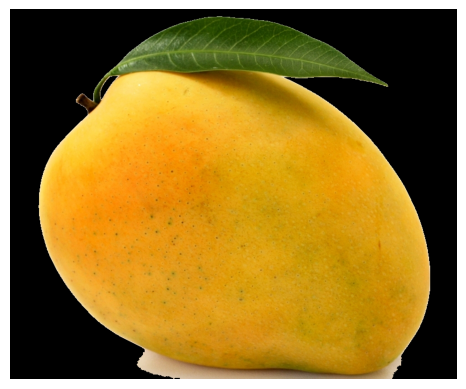

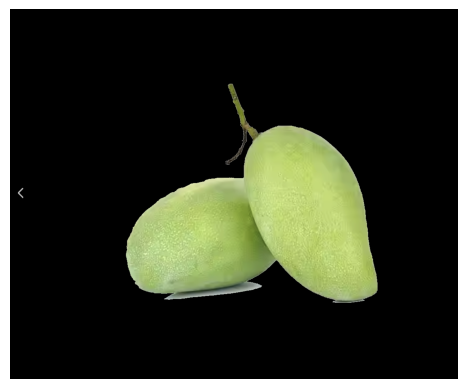

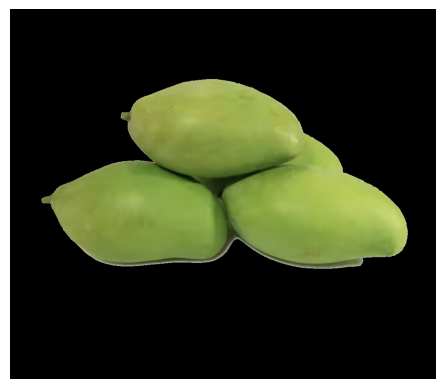

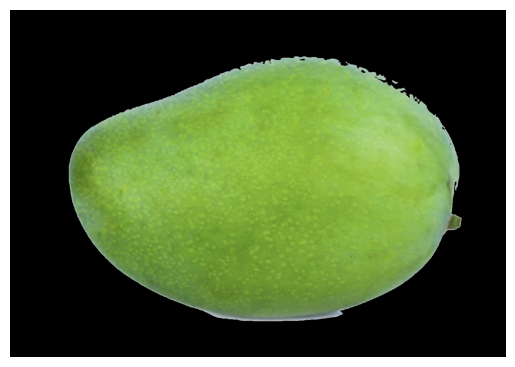

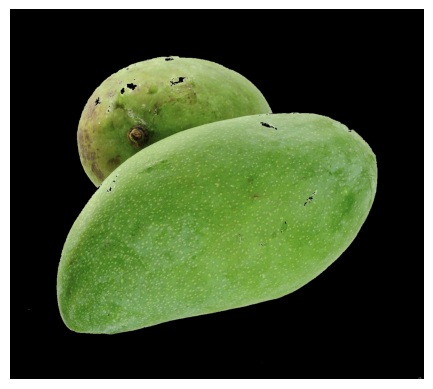

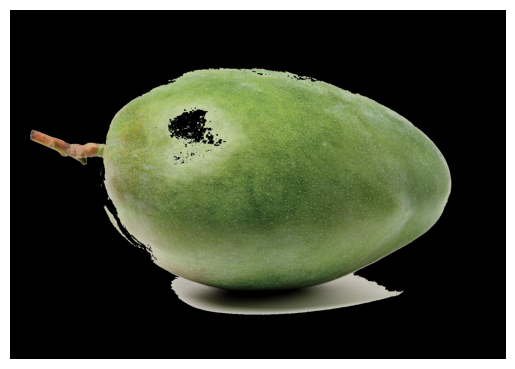

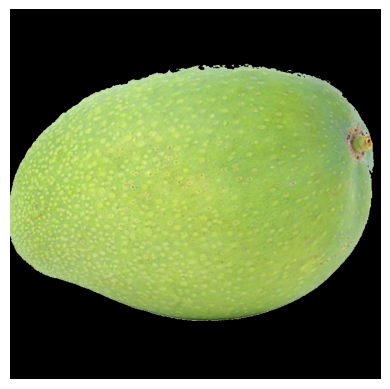

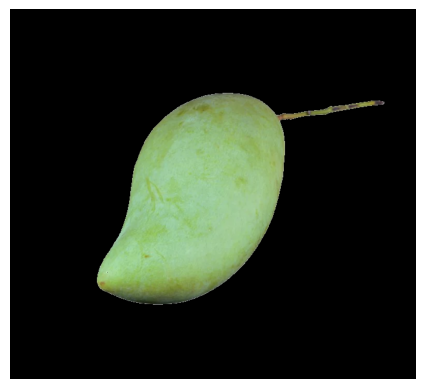

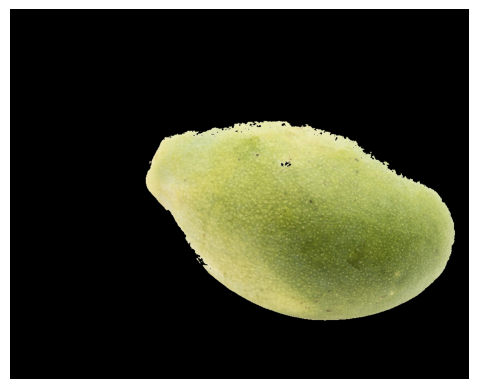

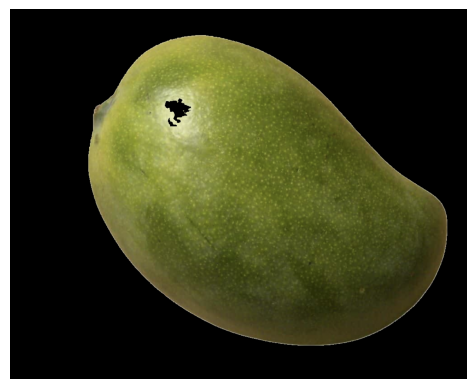

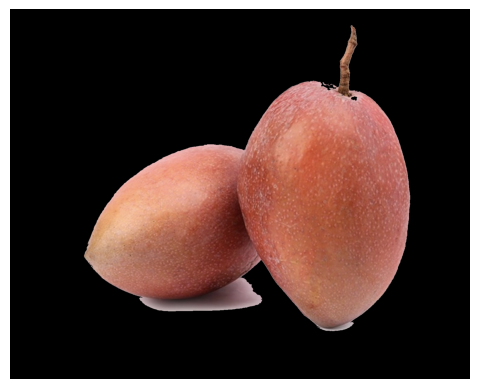

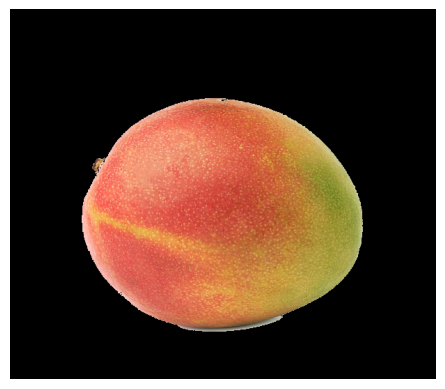

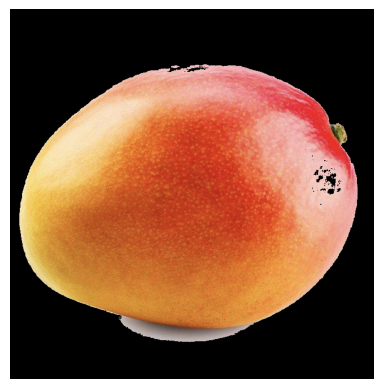

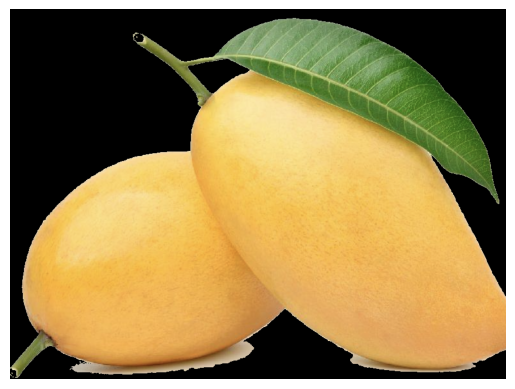

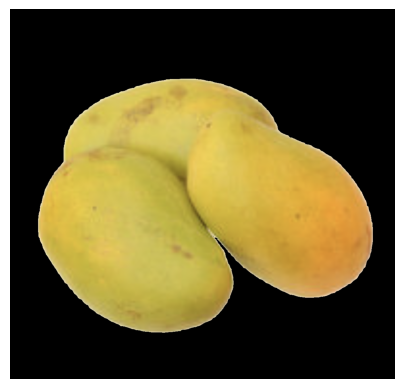

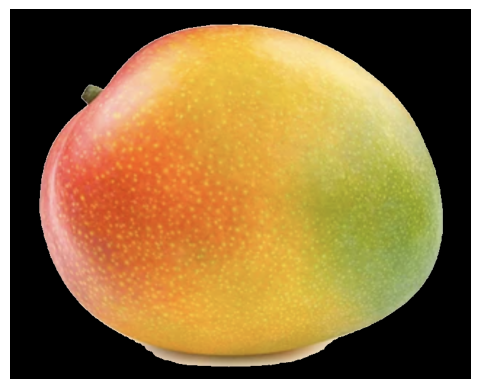

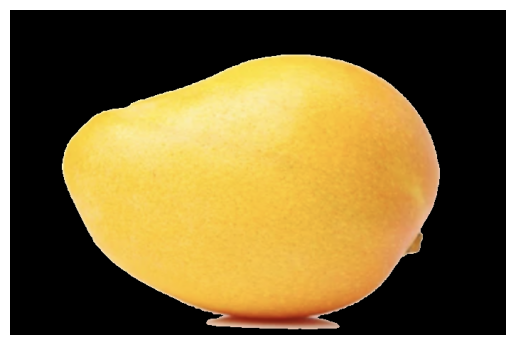

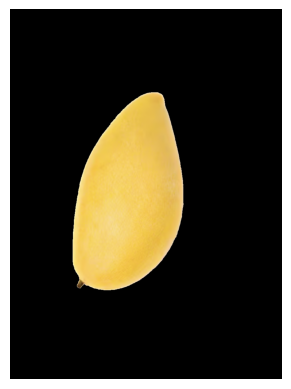

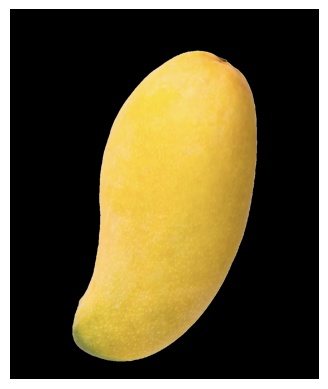

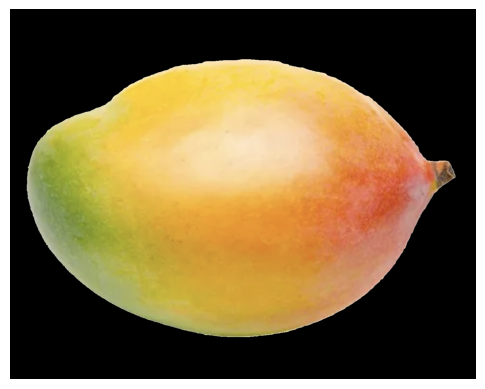

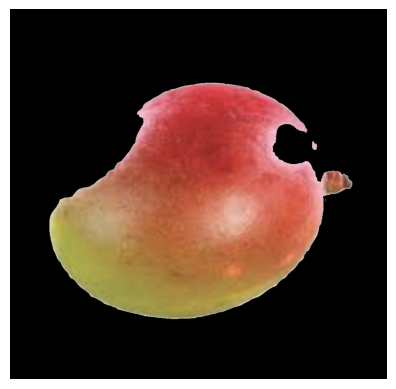

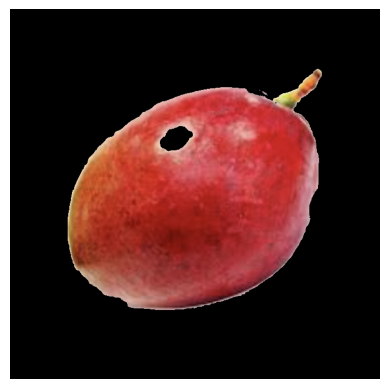

In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt

image_folder = 'Mango'

# Hàm xử lý ảnh: chuyển background thành màu đen
def process_image(image_path):
    # Đọc ảnh từ file
    img = cv2.imread(image_path)

    # Chuyển ảnh sang không gian màu HSV (dễ phân biệt màu sắc)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    # Định nghĩa phạm vi màu của background (trắng hoặc màu sáng)
    lower_white = np.array([0, 0, 200])  # Giới hạn thấp cho màu sáng
    upper_white = np.array([200, 50, 255])  # Giới hạn cao cho màu sáng

    # Tạo mặt nạ để lọc background
    mask = cv2.inRange(hsv, lower_white, upper_white)

    # Invert mặt nạ (chỉ giữ lại foreground)
    mask_inv = cv2.bitwise_not(mask)

    # Chuyển background thành màu đen
    img_result = cv2.bitwise_and(img, img, mask=mask_inv)

    return img_result

# Duyệt qua tất cả các ảnh trong thư mục và lưu lại ảnh đã xử lý
output_folder = 'processed_mango_images'
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for filename in os.listdir(image_folder):
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_path = os.path.join(image_folder, filename)

        # Tiền xử lý ảnh
        processed_img = process_image(image_path)

        # Lưu ảnh đã xử lý vào thư mục output
        output_path = os.path.join(output_folder, filename)
        cv2.imwrite(output_path, processed_img)

        plt.imshow(cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.show()


In [2]:
# Nhãn theo dữ liệu bạn đã cung cấp (0 là chua, 1 là ngọt)
labels_dict = {
    1: 1, 2: 1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1, 8: 1, 9: 1,
    10: 0, 11: 0, 12: 0, 13: 0, 14: 0, 15: 0, 16: 0, 17: 0, 18: 0,
    19: 1, 20: 1, 21: 1, 22: 1
}

# Danh sách để lưu trữ màu sắc và nhãn
mango_colors = []
labels = []

# Hàm lấy màu trung bình của ảnh
def get_average_color(image_path):
    img = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Chuyển sang RGB
    avg_color = np.mean(img_rgb, axis=(0, 1))  # Tính màu trung bình
    return avg_color

# Duyệt qua tất cả các ảnh trong thư mục và gán nhãn
for filename in os.listdir(output_folder):  # Sử dụng thư mục chứa ảnh đã xử lý
    if filename.endswith(".jpg") or filename.endswith(".png"):
        image_number = int(filename.split('.')[0])  # Lấy số ảnh từ tên tệp
        if image_number in labels_dict:
            label = labels_dict[image_number]

            image_path = os.path.join(output_folder, filename)

            # Lấy màu trung bình của ảnh đã xử lý
            avg_color = get_average_color(image_path)

            mango_colors.append(avg_color)
            labels.append(label)

# Chuyển thành mảng numpy để sử dụng trong mô hình
X = np.array(mango_colors)
y = np.array(labels)


In [3]:
from sklearn.preprocessing import StandardScaler

# Chuẩn hóa dữ liệu màu sắc
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [4]:
from sklearn.model_selection import train_test_split

# Chia dữ liệu thành bộ train và test (80% huấn luyện, 20% kiểm tra)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

LOOCV Accuracy: 95.45%


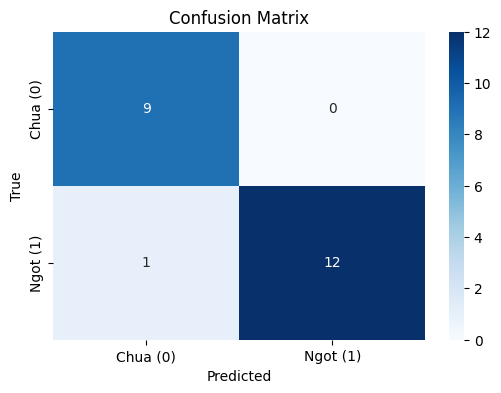

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import LeaveOneOut
import seaborn as sns

# Tạo mô hình phân loại
model = LogisticRegression()

# Khởi tạo LOOCV
loo = LeaveOneOut()

# Tạo danh sách để lưu trữ các dự đoán và giá trị thực tế
y_true = []
y_pred = []

# Thực hiện LOOCV
for train_index, test_index in loo.split(X):
    # Chia dữ liệu thành tập huấn luyện và kiểm tra
    X_train_loo, X_test_loo = X[train_index], X[test_index]
    y_train_loo, y_test_loo = y[train_index], y[test_index]
    
    # Huấn luyện mô hình trên tập huấn luyện
    model.fit(X_train_loo, y_train_loo)
    
    # Dự đoán trên tập kiểm tra (chỉ có 1 mẫu trong LOOCV)
    pred = model.predict(X_test_loo)
    
    # Lưu trữ giá trị thực tế và dự đoán
    y_true.append(y_test_loo[0])
    y_pred.append(pred[0])

# Đánh giá mô hình
accuracy = accuracy_score(y_true, y_pred)
accuracy_percentage = accuracy * 100
print(f"LOOCV Accuracy: {accuracy_percentage:.2f}%")


# Tính toán ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)

# Hiển thị ma trận nhầm lẫn bằng heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Chua (0)', 'Ngot (1)'], 
            yticklabels=['Chua (0)', 'Ngot (1)'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The predicted sweetness label is: 0


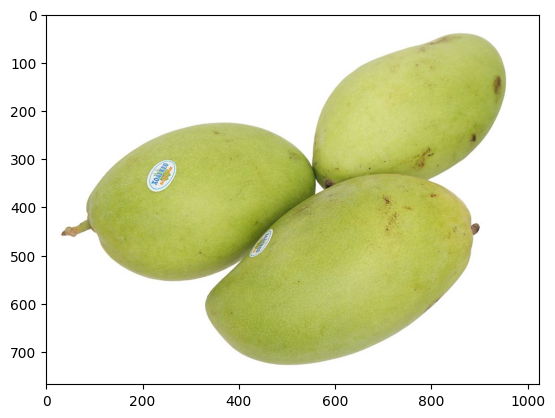

In [12]:
def predict_mango_sweetness(image_path):
    processed_img = process_image(image_path)  # Tiền xử lý ảnh mới
    avg_color = get_average_color(image_path)  # Lấy màu trung bình
    avg_color_scaled = scaler.transform([avg_color])  # Chuẩn hóa màu sắc
    label = model.predict(avg_color_scaled)  # Dự đoán nhãn
    return label[0]

# Dự đoán cho ảnh mới
new_image_path = "E:/AI/test 1.jpg"
img = cv2.imread(new_image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
predicted_label = predict_mango_sweetness(new_image_path)
print(f"The predicted sweetness label is: {predicted_label}")


The predicted sweetness label is: 1


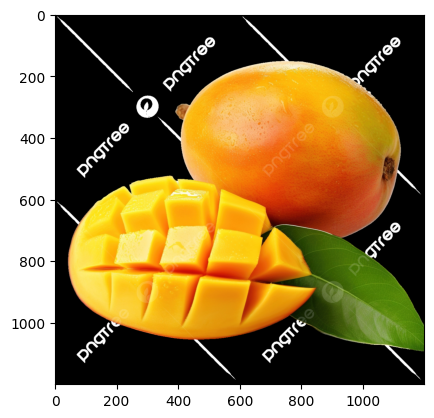

In [13]:
def predict_mango_sweetness(image_path):
    processed_img = process_image(image_path)  # Tiền xử lý ảnh mới
    avg_color = get_average_color(image_path)  # Lấy màu trung bình
    avg_color_scaled = scaler.transform([avg_color])  # Chuẩn hóa màu sắc
    label = model.predict(avg_color_scaled)  # Dự đoán nhãn
    return label[0]

# Dự đoán cho ảnh mới
new_image_path = "E:/AI/test 2.png"
img = cv2.imread(new_image_path)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
predicted_label = predict_mango_sweetness(new_image_path)
print(f"The predicted sweetness label is: {predicted_label}")
